# 응용통계학 발표 
## chess game data를 이용한  승패 예측 로지스틱 모형 구현

---

## `-` 1. data 불러오기 및 설명

- kaggle의 mysar ahmad bhat user가 21년도에 제작한 dataset
- 온라인 체스게임 진행중 측정된 기록에 대한 데이터 프레임 

data 출처 : https://www.kaggle.com/datasets/mysarahmadbhat/online-chess-games

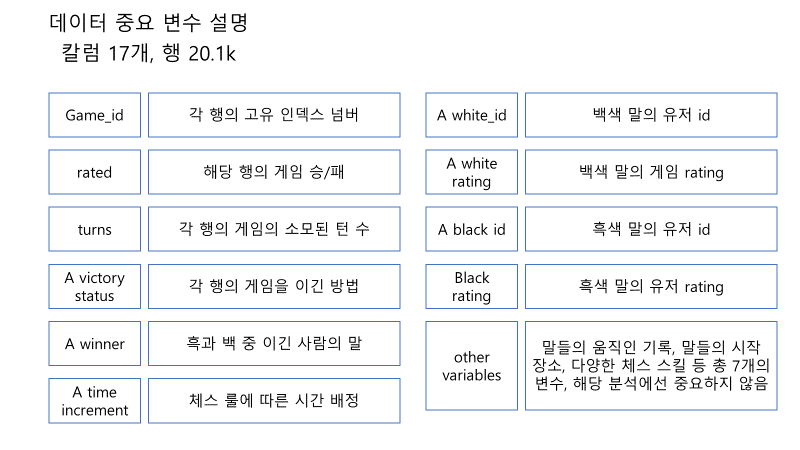

- other variables : chess domain에서 승패를 가르는데 있어 매우 중요한 역할을 함, 하지만 그 변수들 중에 1개를 제외한 6개의 변수는 위치가 기록되어있는 문자형 데이터 또는 chess에 대한 깊은 지식이 필요한 문자형데이터로 이루어진 변수이다. 따라서 연속형변수가 아닐뿐더러 범주형 변수로 처리하여 회귀모형에 적합하는 것은 어려워 보이기 때문에 해당 과제에서는 체스 말의 위치정보와 관련된 변수 7개는 제외하였음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
df = pd.read_csv("C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\data\\chess\\chess_games.csv")

In [3]:
df.head()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


In [4]:
# 필요 데이터만 get
# game_id -> index와 동일하기 때문에 삭제
target = df.iloc[:,1:-7]

In [5]:
target#.describe()

,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating
0,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191
1,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261
2,True,61,Mate,White,5+10,ischia,1496,a-00,1500
3,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454
4,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469
...,...,...,...,...,...,...,...,...,...
20053,True,24,Resign,White,10+10,belcolt,1691,jamboger,1220
20054,True,82,Mate,Black,10+0,jamboger,1233,farrukhasomiddinov,1196
20055,True,35,Mate,White,10+0,jamboger,1219,schaaksmurf3,1286
20056,True,109,Resign,White,10+0,marcodisogno,1360,jamboger,1227


---
## data 변수 EDA 

## 1. rated

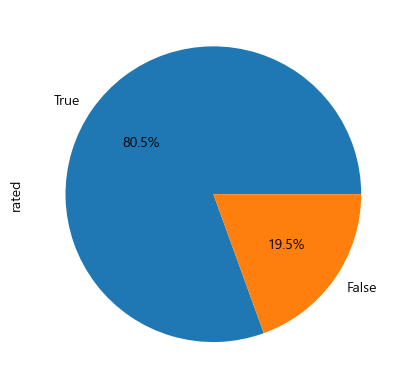

In [6]:
target['rated'].value_counts().plot(kind='pie', autopct='%1.1f%%');

- rated
    - True와 False로 이루어진 범주형 변수
    - 경기를 치룰 때 rating 점수가 올라가면 true로 입력되어진다.
    - rated가 false라는 의미는 두 유저의 rating의 격차가 매우 크다는 의미로 실력차이가 큰 상대에게서 승리 했을 때,
    rating 점수를 부여하지 않겠다는 의미
- 해석 : true가 80.5%, false가 19.5%의 비율을 가지고 있다. 이는 유저 매칭이 이루어졌을 때, 실력 차가 크지 않는 유저끼리 대부분 경기가 이루어지는 것을 알 수 있다. 하지만 실력 차가 큰 상대와 맞붙는 다는 것은 경쟁게임에서 원활한 게임성을 해치는 요소로 간주하기 때문에 약 20%가량의 false 분포는 상당히 적지 않은 비율로 볼 수 있을 것 같다. 

---
## 2. turns

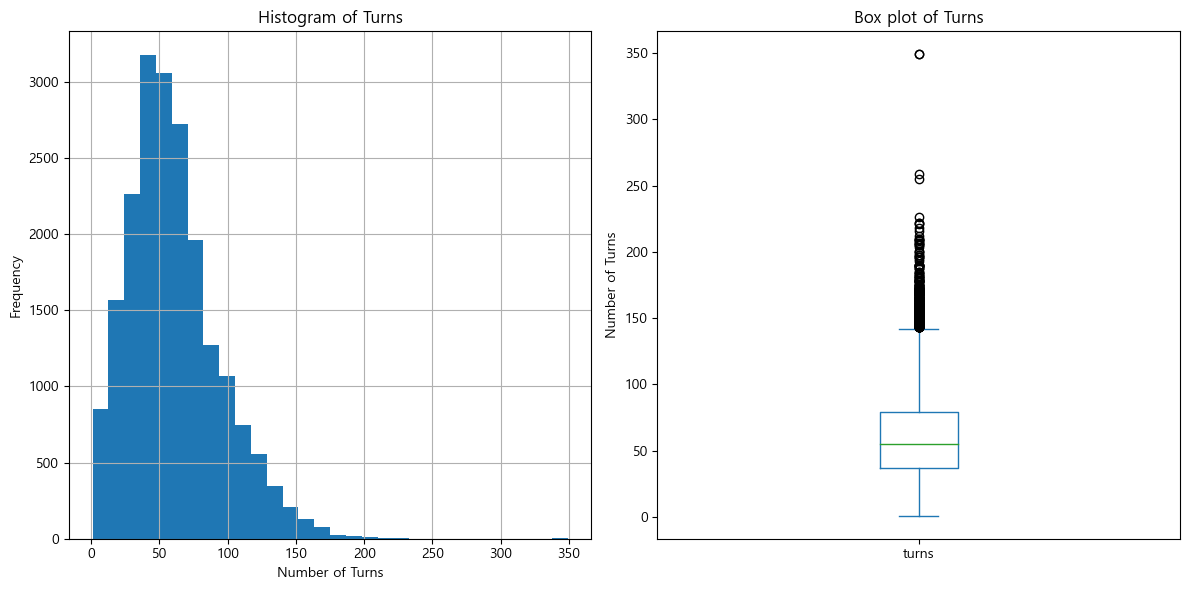

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

target['turns'].hist(bins=30, ax=axs[0])
axs[0].set_title('Histogram of Turns')
axs[0].set_xlabel('Number of Turns')
axs[0].set_ylabel('Frequency')
target['turns'].plot(kind='box',ax=axs[1])
axs[1].set_title('Box plot of Turns')
axs[1].set_ylabel('Number of Turns')

plt.tight_layout()  
plt.show()

In [8]:
target['turns'].describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

- turns 
    - 양의 숫자로 이루어진 연속형 변수
    - 한 플레이어가 말을 한번 움직이고 상대 플레이어가 말을 한번 움직인 상태
- 해석
    - 평균은 60, 표준편차는 33으로 분산이 크다
    -  히스토그램을 보았을 때 오른쪽으로 꼬리가 길게 쌓여 있다. 
    - 박스플랏을 통해서도 수치가 높은 이상치가 나타난 것을 확인
    - 이들은 게임을 이기기위해 필요한 턴이 어떤 조건(상대와의 실력차, 체스 전략의 부재 등)이 통하지 않는다면
    제로게임이 되는 체스 룰 상 소모된 턴이 훨씬 많아지는 것을 뒷받침해줌
    - 다만 각 게임에 배정된 시간이 다르다. 따라서 공통적으로 시간을 묶어서 분류하고 다시 분포를 확인할 필요가 있음


---
## 3. victory_status

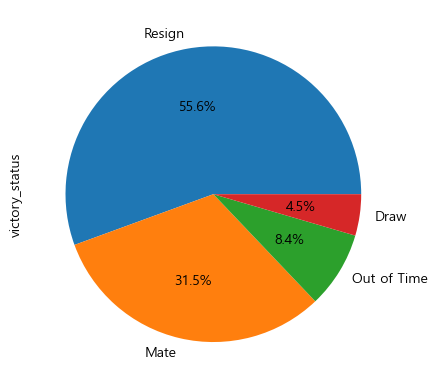

In [9]:
target['victory_status'].value_counts().plot(kind='pie', autopct='%1.1f%%');

- victory_status
    - 게임에서 어떻게 이기게 되었는지에 대한 변수
        - resign : 기권
        - mate : 상대편 king을 움직일 수 없게 만듦
        - out of time : 시간 초과로 인한 패배
        - draw : 무승부
    - 기권이 가장 많은 비율을 차지 하고 있다. 이는 체스게임에서는 플레이어가 몇 수를 앞서 생각해 본인이 패배할 것이 확실해진다면 항복을 미리 하기 때문, 이는 체스게임에서 스포츠맨십에 해당한다. 따라서 본인이 패배하게 되는 것이 뚜렷하다면 게임을 더 끌고가지 않는 경향이 있다
    - resign은 결국 게임을 계속 끌고간다면 mate가 된다. 따라서 resign과 mate는 서로 관련이 있다고 볼 수 있다.

---
## 5. winner

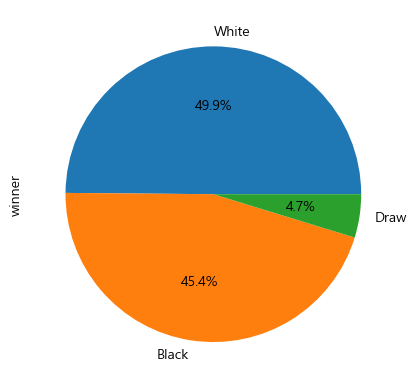

In [10]:
target['winner'].value_counts().plot(kind='pie', autopct='%1.1f%%');

- winner
    - 승리한 말의 색깔을 의미한다.
    - 백색 말은 게임을 먼저 시작하는 말이다. 서로 동등한 실력일 경우 먼저 시작하는 것이 엄청난 메리트라고 알려져 있다.
    - 따라서 백색 말의 승리 비율이 검정말보다 근소하게 높은 것을 알 수 있다. 

---
## 6. time increment

- 체스 룰에 따른 시간 배정을 의미한다.
- 15|10은 기본시간 15분에 증정시간 10초를 의미한다. 따라서 60수를 두었다면 15분 + 10 * 60 초가 되는 것
- 해당 데이터에서는 무수히 많은 배정시간이 존재한다. 
- 배정시간에 따라 turns수가 변한다고 가정할 때 앞으로 모형적합에 있어서 배정시간을 고정해야할 필요가 있어보인다. 따라서 배정시간에 따라 turns의 유의한 차이가 있는지 우선적으로 알아보려한다.

In [11]:
time= np.array([v for v in set(target['time_increment'])])

In [89]:
# 충분한 플레이 수가 있는 배정시간 추출
time[np.array([sum(target['time_increment'] == time[i]) for i in range(len(time))]) > 500]

array(['10+0', '5+8', '5+5', '15+15', '10+5', '8+0', '15+0'], dtype='<U7')

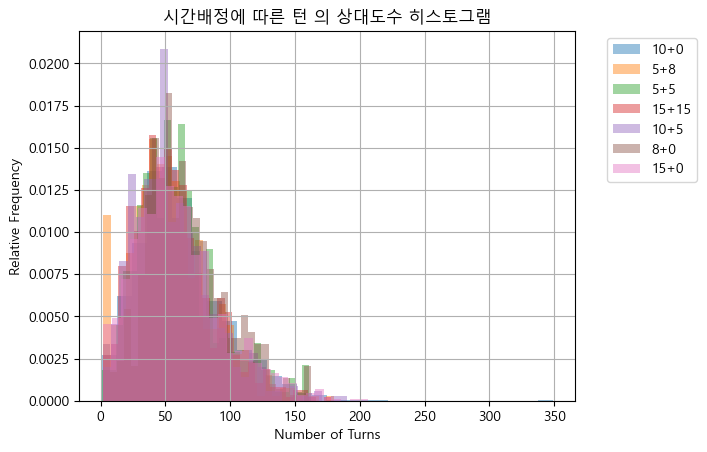

In [93]:

for time_increment in time[np.array([sum(target['time_increment'] == time[i]) for i in range(len(time))]) > 500]:
    target[target['time_increment'] == time_increment]['turns'].hist(bins=30,alpha=0.45, density=True, label=time_increment)

plt.title('시간배정에 따른 턴 의 상대도수 히스토그램')
plt.xlabel('Number of Turns')
plt.ylabel('Relative Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


- 위 6가지 타임룰이 전체 데이터의 절반이 넘는다
- 충분한 플레이타임이 쌓였을 때, 시간배정에 따른 분포의 변화가 엄청 두드러지지 않는 것으로 보인다.
- 시간에 상관없이 소모되는 턴 수는 대부분 비슷한 것으로 보임
- 물론 엄밀한 검정을 진행하지 않았지만 앞으로의 모형적합에 있어 충분한 플레이 빈도가 있는 경우 시간배정에 따른 차이는 고려하지 않겠다. 

---
## 7. 유저 id에 따른 체스 말의 rating score

- 검정말과 백색말 각각의 rating의 분포확인
- 검정말, 백색말의 유저 id 변수를 이용해 중복 기록된 유저를 파악할 수 있다
- 시간에 경과에 따른 최종 rating이 파악되지 않기 때문에 중복으로 rating이 존재하는 유저인 경우, 해당 유저의 rating 결과를 평균내어 산출하도록함

In [14]:
w_id = [v for v in set(target['white_id'])]
b_id = [v for v in set(target['black_id'])]

In [15]:
# 흑색말의 유저 id 숫자
len([v for v in set(target['black_id'])])

9331

In [16]:
# 백색말의 유저 id 숫자
len([v for v in set(target['white_id'])])

9438

In [17]:
# 백색과 흑색의 중복 id 숫자
len([v for v in set(w_id)&set(b_id)])

3134

In [18]:
# 백색과 흑색의 합집합 id 숫자
len([v for v in set(w_id)|set(b_id)])

15635

In [19]:
# 유저별 평균 레이팅 딕셔너리
mean_ratings = {}

for white_id in w_id:
    mean_rating = target[target['white_id'] == white_id]['white_rating'].mean()
    mean_ratings[white_id] = mean_rating

mean_ratings2 = {}

for black_id in b_id:
    mean_rating2 = target[target['black_id'] == black_id]['black_rating'].mean()
    mean_ratings2[black_id] = mean_rating2



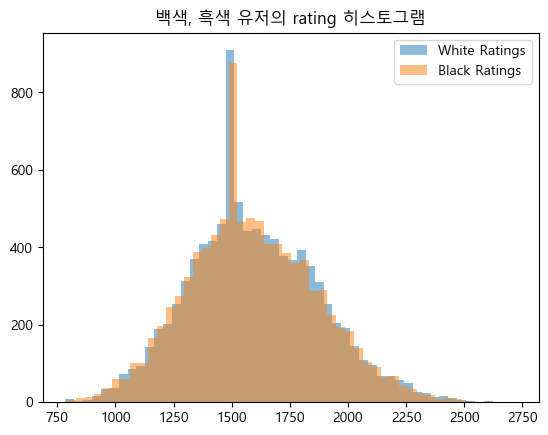

In [20]:
# 중복 id 제거
plt.hist([i for k,i in mean_ratings.items()], bins=50,alpha=0.5,label='White Ratings')
plt.hist([i for k,i in mean_ratings2.items()], bins=50,alpha=0.5,label='Black Ratings')
plt.title("백색, 흑색 유저의 rating 히스토그램")
plt.legend()
plt.show()

- 말 색깔에 따른 레이팅의 차이는 크지 않다.
    - 앞서 백색말이 승률이 조금 높은 것을 원그래프를 통해 알 수 있었는데 rating 히스토그램에 반영된 것을 확인할 수 있다.
    - 특정 뾰족한 탑이 생성되었다. 여러가지 원인을 가정해볼 수 있다.
        - 게임 생성 때 주어진 기본 레이팅이 1500이다.
        - 한 유저의 여러 플레이기록에 따른 레이팅의 변화를 평균처리함으로서 생겨난 것이다
        - 다만 백색과 흑색의 레이팅 분포의 차이가 크지 않다는 것을 알 수 있고 과제 주제와 큰 연관이 없기 때문에 보류 


- 레이팅은 본인의 실력을 가늠해주는 지표이다.
- 하지만 승패 유무에 있어 본인의 레이팅 점수자체가 중요한 것은 아니다. 본인이 레이팅이 높아도 상대 또한 나와 비슷한 레이팅이라면 승패를 예측하기 어려워지기 때문이다.
- 따라서 본인의 레이팅만이 아닌 상대 레이팅과 **차이**가 얼마나 크냐에 따라서 승패를 예측해볼 수 있는 중요한 지표가 될 것으로 보인다
- 백색과 흑색의 레이팅은 매우 동일한 분포를 가지고, 각각의 레이팅은 다른 유저 id이기 때문에 이들의 레이팅은 서로 독립적인 변수이다. 이들의 차이 또한 독립변수라고 생각할 수 있다.

In [21]:
# 검정말과 힌말의 유저 id 통합
#wb_id = [v for v in set(w_id)|set(b_id)]
#result = []
#for player in wb_id:
#    # 'ekber' 키가 존재하는지 확인하고 있다면 해당 값을 결과에 추가
#    if player in mean_ratings and player in mean_ratings2:
#        result.append((mean_ratings[player], mean_ratings2[player]))
#    else:
#        # 'ekber' 키가 존재하지 않는 경우 해당 플레이어의 값을 0으로 처리하여 결과에 추가
#        result.append((mean_ratings.get(player, 0), mean_ratings2.get(player, 0)))


---
## EDA 정리

- rated, turns, victory status, winner, time increment, whith id, white rating, black id, black rating 총 9개의 변수를 이용하여 EDA를 진행해보았다
- 과제에 설정했던 문제는 체스게임 승패 예측이기 때문에 종속변수는 winner이고 2개의 클래스 분류문제이다.
    - 해당 과제에서는 draw를 고려하지 않으려고 한다. 승패로만 분류할 것임 
    - 따라서 로지스틱회귀모형을 적합하는 것이 알맞아 보인다.
- 설명변수로 소모된 턴, 레이팅의 차이를 사용하려 한다.
    -  victory status는 승패가 정해진 후 결정되는 요소이기때문에 고려 x
    - rated는 레이팅 점수가 올랐는지의 여부는 레이팅의 차이와 긴밀하기 때문에 고려x
- 제한 조건은 동일한 게임룰에 진행된 데이터만 사용하려고 한다. 따라서 충분한 판수가 보장된 time increment에서 데이터를 추출하겠다.


---
## 변수 설정

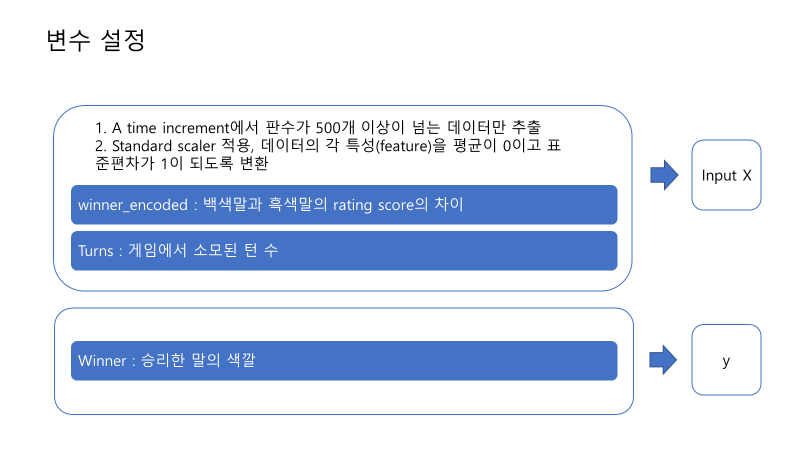

`-` X 정의
$$
X_{14331\ \times \ i} =
\begin{cases}
i =1, & \mbox{소모된 턴} \\
i =2, & \mbox{레이팅점수 차이}
\end{cases} \\
$$

`-` y 정의
$$
y_{14331\ \times \ 1} =
\begin{cases}
1, & \mbox{white} \\
0, & \mbox{black}
\end{cases} \\
$$

In [94]:
# 'time_increment' 열에서 '15+15', '5+5', '8+0', '5+8', '10+5', '10+0'를 만족하는 행만 선택
filtered_df = target[target['time_increment'].str.contains('15\+15|5\+5|8\+0|5\+8|10\+5|10\+0')]

In [364]:
filtered_df= filtered_df[filtered_df['winner'] != 'Draw']
filtered_df['rating_difference'] = filtered_df['white_rating'] - filtered_df['black_rating']


from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용하여 'winner' 열의 값을 0과 1로 변환
encoder = LabelEncoder()

filtered_df['winner_encoded'] = encoder.fit_transform(filtered_df['winner'])
filtered_df['rated_encoded'] = encoder.fit_transform(filtered_df['rated'])

In [378]:
X = filtered_df.loc[:,['turns','rating_difference']]
y = filtered_df.loc[:,['winner_encoded']]
from sklearn.preprocessing import *

standard = StandardScaler()
scale_X_= standard.fit_transform(X)


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(scale_X_,y,random_state=1)

---

## 로지스틱 모형 구현 및 적합

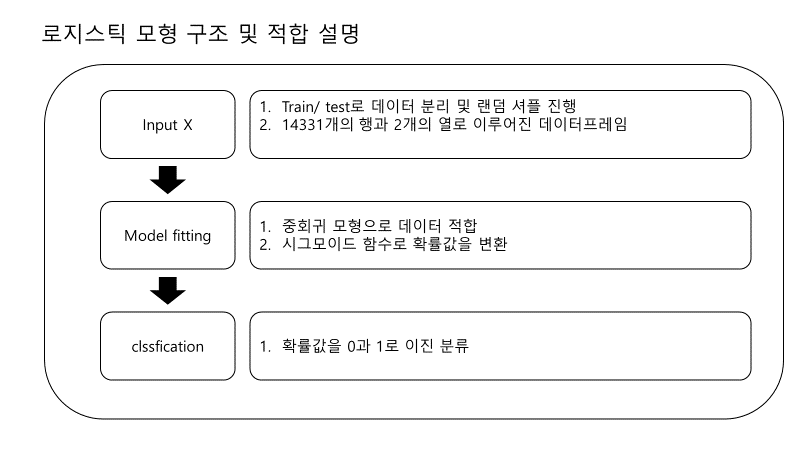

`-` 모형 정의
$$
y= X B + \epsilon, \epsilon \sim iid,\ N(0,I\sigma^2)
$$
`-` model fitting

$$
\hat{y}= X \hat{B}
$$

`-` sigmoid

$$
\frac{1}{ 1+e^{- X \hat{B}}}
$$

In [379]:
class Logistic:
    '''
    [로지스틱 회귀 이진 분류모형]
    
    입력 변수 : 설명변수 X, 이진 분류 y
    fit : 데이터 모형적합, 행렬기반 계산, 계수 추정
    sigmoid : fitted된 모형을 sigmoid함수로 변환
    boundary : sigmoid로 나온 확률 값을 1과 0으로 분류
    predict : fitted된 모형을 기반으로 새로운 X에 대해 예측
    '''
    def __init__(self,X,y):
        self.X = X
        self.y = y
        print("using dataframe is well good")

    def fit(self):
        xtx_inv= np.linalg.inv(np.dot(self.X.T,self.X))
        self.coef= np.dot(xtx_inv,self.X.T) @ self.y
        self.fitted_value = self.X @ self.coef
        self.fit_sigmoid= self.sigmoid(self.X @ self.coef)
        return self.fit_sigmoid
    
    def sigmoid(self, z): 
        self.sig_z = 1 / (1 + np.exp(-z))
        return self.sig_z 
    
    def boundary(self, threshold):
        return (self.fit_sigmoid >threshold)*1
    
    def predict(self, x_test, threshold):
        x_test @ self.coef
        self.test_sig = self.sigmoid(x_test @ self.coef)
        self.prob = (self.test_sig >threshold)*1
        return self.prob

In [380]:
lr = Logistic(X_train,y_train)

using dataframe is well good


In [381]:
# 모형적합
lr.fit()
lr.boundary(0.5)
lr.predict(X_test,0.5)

,winner_encoded
0,1
1,1
2,0
3,0
4,1
...,...
2775,1
2776,0
2777,0
2778,1


---
## 혼동행렬
- accuracy 계산
- 정밀도 계산
- 민감도 계산


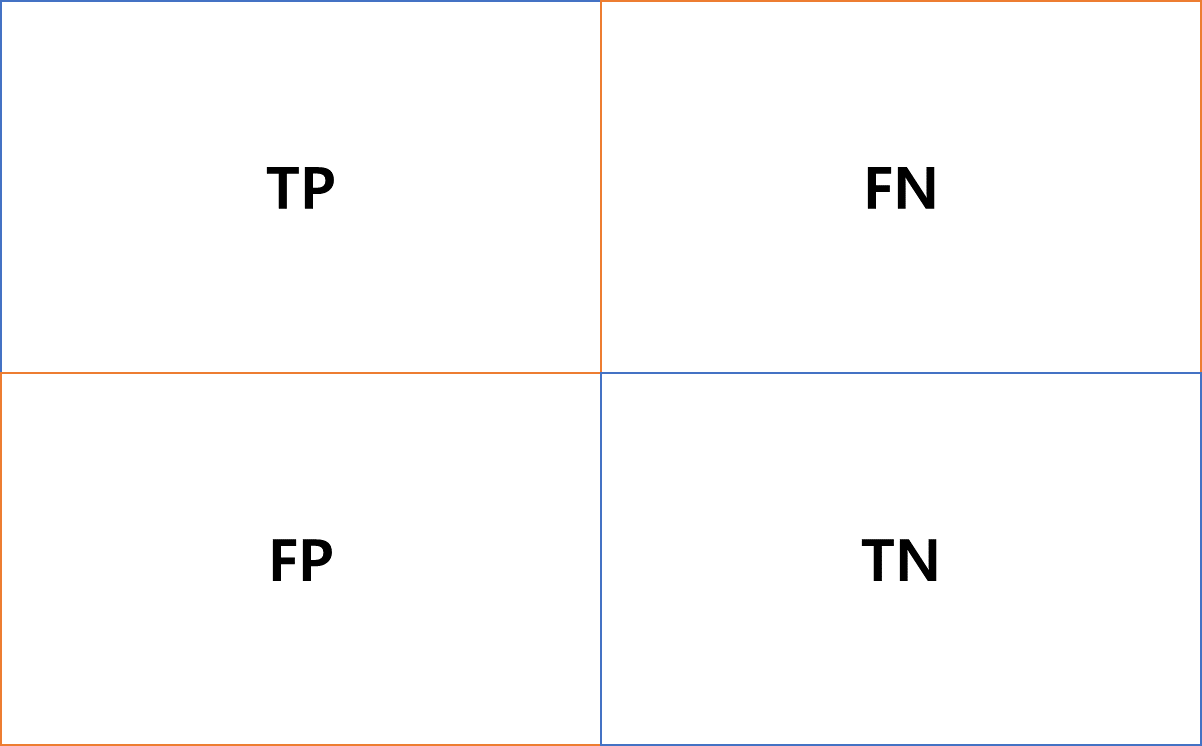
- TP : 실제 true, 예측 positive
- FP : 실제 false, 예측 positive
- FN : 실제 true, 예측 nagaitve
- TN : 실제 false, 예측 nagaitve

In [408]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test,lr.prob)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[905 430]
 [507 938]]


### accuracy
- TP + TN /( TP + TN + FP + FN)

In [409]:
sum(conf_matrix.diagonal()) / conf_matrix.sum() 

0.6629496402877698

### 민감도
- TP /( TP + FP)

In [410]:
conf_matrix[0,0]/ conf_matrix.sum(axis=1)[0] 

0.6779026217228464

### 특이도
- TN / (TP + FP)

In [411]:
conf_matrix[1,1]/ conf_matrix.sum(axis=1)[1]

0.6491349480968858

---
## 비교1 :  로지스틱 모형이 잘 작동하는지 
- 패키지 모듈과 비교

In [412]:
from sklearn.linear_model import LogisticRegression


logistic_regression_model = LogisticRegression()

# 모델 학습
logistic_regression_model.fit(X_train, y_train.values.ravel())

# 학습된 모델을 사용하여 예측 수행
#y_pred = logistic_regression_model.predict(X_test)


LogisticRegression()

In [413]:
pred = logistic_regression_model.predict(X_test)

In [414]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
accuracy = accuracy_score(y_test, pred)
# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, pred)

# 분류 보고서 출력
class_report = classification_report(y_test,pred)

# 결과 출력
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.6618705035971223
Confusion Matrix:
 [[ 802  533]
 [ 407 1038]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63      1335
           1       0.66      0.72      0.69      1445

    accuracy                           0.66      2780
   macro avg       0.66      0.66      0.66      2780
weighted avg       0.66      0.66      0.66      2780



---
##  두 모형의 ROC 커브 비교

In [415]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, lr.test_sig)
roc_auc = auc(fpr, tpr)

y_probs = logistic_regression_model.predict_proba(X_test)[:, 1]

# ROC 커브를 계산합니다.
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_probs)

# AUC 값을 계산합니다.
roc_auc1 = auc(fpr1, tpr1)

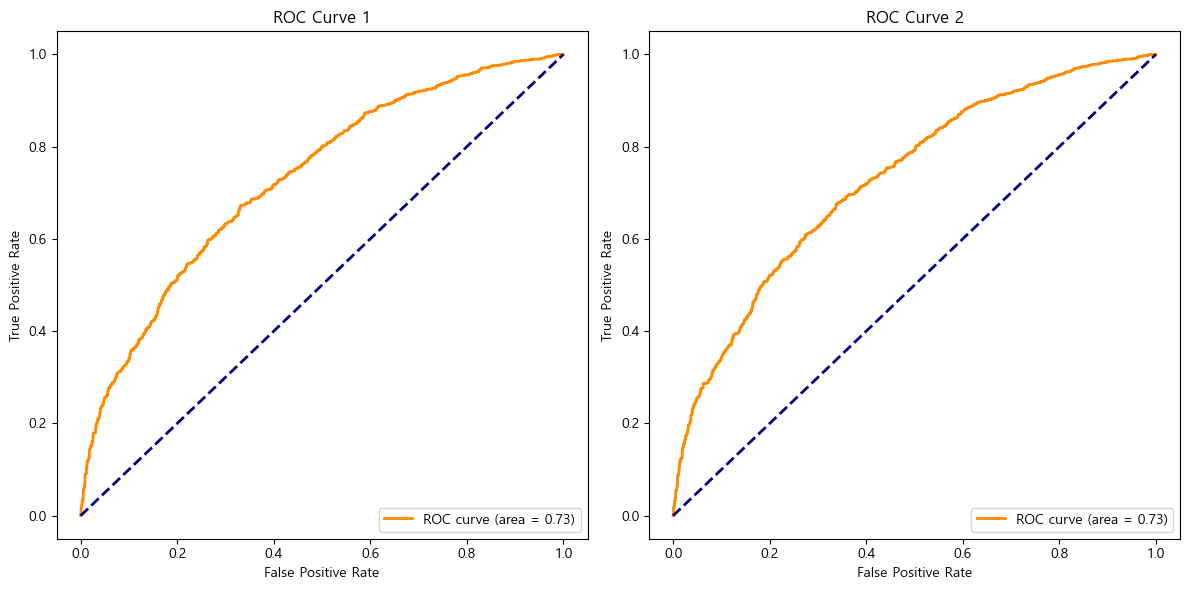

In [416]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting the first ROC curve
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve 1')
axs[0].legend(loc="lower right")

# Plotting the second ROC curve
axs[1].plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve 2')
axs[1].legend(loc="lower right")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [417]:
roc_auc, roc_auc1

(0.7298754584451097, 0.7302170729494706)

---
## 비교2 : 변수를 적절하게 선택했는지

- 임의의 변수 처리와 파생변수를 사용하지 않고 전체 데이터를 전부 적합
- time_increment는 동일하게 설정
- whith_id, black_id, victory_status 사용하지 않음

In [351]:
X_con = filtered_df.loc[:,['turns','rated_encoded','black_rating','white_rating']]
y_con = filtered_df.loc[:,['winner_encoded']]

In [352]:
minmax2= MinMaxScaler()
scale_X_con = minmax2.fit_transform(X_con)

In [353]:
X_train2,X_test2,y_train2,y_test2= train_test_split(scale_X_con ,y_con)

In [354]:
logistic_regression_model2 = LogisticRegression()

# 모델 학습
logistic_regression_model2.fit(X_train2 , y_train2.values.ravel())

LogisticRegression()

In [355]:
pred2 = logistic_regression_model2.predict(X_test2)

In [356]:
accuracy = accuracy_score(y_test, pred2)
# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, pred2)

# 분류 보고서 출력
class_report = classification_report(y_test,pred2)

# 결과 출력
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5161870503597122
Confusion Matrix:
 [[566 765]
 [580 869]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.43      0.46      1331
           1       0.53      0.60      0.56      1449

    accuracy                           0.52      2780
   macro avg       0.51      0.51      0.51      2780
weighted avg       0.51      0.52      0.51      2780



---
## 앙상블

In [357]:
from sklearn.tree import DecisionTreeClassifier

dc = DecisionTreeClassifier()
dc.fit(X_train, y_train)
y_pred_dc = dc.predict(X_test)

In [358]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 생성
random_forest_model = RandomForestClassifier()

# 모델 학습
random_forest_model.fit(X_train, y_train.values.ravel())

# 모델 예측
y_pred_rf = random_forest_model.predict(X_test)


In [359]:
import xgboost as xgb

# XGBoost 모델 생성
xgboost_model = xgb.XGBClassifier()

# 모델 학습
xgboost_model.fit(X_train, y_train)

# 모델 예측
y_pred_xgb = xgboost_model.predict(X_test)


In [360]:
import lightgbm as lgb

# LightGBM 모델 생성
lightgbm_model = lgb.LGBMClassifier()

# 모델 학습
lightgbm_model.fit(X_train, y_train.values.ravel())

# 모델 예측
y_pred_lgbm = lightgbm_model.predict(X_test)


[LightGBM] [Info] Number of positive: 4325, number of negative: 4014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518647 -> initscore=0.074624
[LightGBM] [Info] Start training from score 0.074624


In [361]:
accuracy_dc = accuracy_score(y_test, y_pred_dc)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_dc, accuracy_rf,accuracy_xgb ,accuracy_lgbm

(0.7535971223021583,
 0.7194244604316546,
 0.8888489208633094,
 0.8809352517985611)

In [362]:
from sklearn.ensemble import VotingClassifier
# 보팅 앙상블을 위한 분류기 리스트 생성
estimators = [
    ('DecisionTree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier()),
    ('logistic_regression', LogisticRegression())
]
weights = [1,1, 3] 
# 보팅 분류기 생성 (소프트 보팅)
voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=weights)

# 보팅 분류기 학습
voting_clf.fit(X_train, y_train.values.ravel())

# 보팅 분류기 예측
y_pred_voting = voting_clf.predict(X_test)
accuracy_score(y_test, y_pred_voting)


0.7719424460431654

---

In [297]:
# 절편이 있는 모형

class Logistic:
    '''
    [로지스틱 회귀 이진 분류모형]
    
    입력 변수 : 설명변수 X, 이진 분류 y
    fit : 데이터 모형적합, 행렬기반 계산, 계수 추정
    sigmoid : fitted된 모형을 sigmoid함수로 변환
    boundary : sigmoid로 나온 확률 값을 1과 0으로 분류
    predict : fitted된 모형을 기반으로 새로운 X에 대해 예측
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        print("using dataframe is well good")

    def fit(self):
        beta0 = np.repeat(1, self.X.shape[0])
        X_with_bias = np.concatenate([beta0.reshape(-1, 1),X_train],axis=1)
        xtx_inv = np.linalg.inv(np.dot(X_with_bias.T, X_with_bias))
        self.coef = np.dot(xtx_inv, X_with_bias.T) @ self.y
        self.fitted_value = X_with_bias @ self.coef
        self.fit_sigmoid = self.sigmoid(X_with_bias @ self.coef)
        return self.fit_sigmoid
    
    def sigmoid(self, z): 
        self.sig_z = 1 / (1 + np.exp(-z))
        return self.sig_z 
    
    def boundary(self, threshold):
        return (self.fit_sigmoid > threshold)*1
    
    def predict(self, x_test, threshold):
        beta0 = np.repeat(1, x_test.shape[0])
        x_test_with_bias = np.concatenate([beta0.reshape(-1, 1),X_test],axis=1)
        self.test_sig = self.sigmoid(x_test_with_bias @ self.coef)
        self.prob = (self.test_sig > threshold)*1
        return self.prob
